In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from collections import defaultdict
import copy

In [12]:
# Transformations for data augmentation and normalization
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [13]:
# Function to filter out only cat and dog classes (3 and 5)
def select_cat_dog_classes(dataset):
    selected_indices = []
    updated_targets = []
    for idx, label in enumerate(dataset.targets):
        if label in [3, 5]:  # 3 for cat, 5 for dog
            selected_indices.append(idx)
            updated_targets.append(0 if label == 3 else 1)  # Map cat (3) to 0, dog (5) to 1

    dataset.data = dataset.data[selected_indices]
    dataset.targets = updated_targets
    return dataset

In [14]:
# Loading the CIFAR-10 dataset
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=eval_transform)

train_data = select_cat_dog_classes(train_data)
test_data = select_cat_dog_classes(test_data)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
# Shuffling and splitting the training data into training and validation sets
total_samples = len(train_data)
sample_indices = list(range(total_samples))
np.random.shuffle(sample_indices)

train_size = int(0.8 * total_samples)
train_idx = sample_indices[:train_size]
val_idx = sample_indices[train_size:]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [16]:
# Create datasets with transformations applied
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=eval_transform)

# Applying filtering to the datasets
train_dataset = select_cat_dog_classes(train_dataset)
val_dataset = select_cat_dog_classes(val_dataset)

# Creating DataLoaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=128, sampler=val_sampler)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [17]:
print(f"Training samples: {len(train_idx)}")
print(f"Validation samples: {len(val_idx)}")

Training samples: 8000
Validation samples: 2000


In [20]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

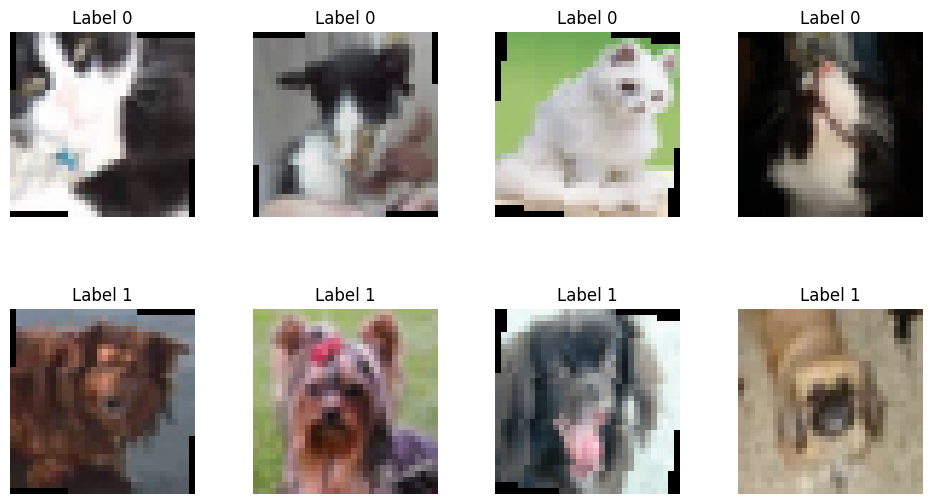

In [24]:
def display_images(data_loader, num_images=2):
    class_images = defaultdict(list)

    for imgs, labels in data_loader:
        for img, label in zip(imgs, labels):
            if len(class_images[label.item()]) < num_images:
                class_images[label.item()].append(img)
            if all(len(images) >= num_images for images in class_images.values()):
                continue

    total_classes = len(class_images)
    fig, axes = plt.subplots(nrows=total_classes, ncols=num_images, figsize=(num_images * 3, total_classes * 3))
    fig.subplots_adjust(hspace=0.5)

    for i, (class_label, images) in enumerate(sorted(class_images.items())):
        for j, img in enumerate(images):

            mean = np.array([0.4914, 0.4822, 0.4465])
            std = np.array([0.2023, 0.1994, 0.2010])
            img = img.numpy().transpose((1, 2, 0))
            img = std * img + mean
            img = np.clip(img, 0, 1)
            axes[i][j].imshow(img)
            axes[i][j].axis('off')
            axes[i][j].set_title(f"Label {class_label}")

    plt.show()

display_images(train_loader, num_images=4)


In [25]:
train_images = []
train_labels = []
val_images = []
val_labels = []

# Collect training and validation data
for images, labels in train_loader:
    train_images.append(images.numpy())
    train_labels.append(labels.numpy())
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

# Concatenate the lists into numpy arrays
X_train = np.concatenate(train_images, axis=0)
y_train = np.concatenate(train_labels, axis=0)
X_val = np.concatenate(val_images, axis=0)
y_val = np.concatenate(val_labels, axis=0)


In [ ]:
class CNNModel(nn.Module):
    def __init__(self,channels,filters, dropout_base):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3,channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels,channels*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(channels*2, filters, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_base)
        self.batch_norm1 = nn.BatchNorm2d(channels)
        self.batch_norm2 = nn.BatchNorm2d(channels*2)
        self.batch_norm3 = nn.BatchNorm2d(filters)

        self.fc1 = nn.Linear(filters * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.batch_norm1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.batch_norm2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.batch_norm3(self.conv3(x))))
        x = self.dropout(x)
        x = x.view(-1, self.flat_features(x))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def flat_features(self, x):
        size = x.size()[1:]
        features = 1
        for s in size:
            features *= s
        return features

In [44]:
#mine
class CNNModel(nn.Module):
    def __init__(self, channels, filters, dropout_base):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(channels*2, filters, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_base)
        self.batch_norm1 = nn.BatchNorm2d(channels)
        self.batch_norm2 = nn.BatchNorm2d(channels*2)
        self.batch_norm3 = nn.BatchNorm2d(filters)

        self.fc1 = nn.Linear(filters * 4 * 4, 1024)  # Adjusting for the new layer
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.batch_norm1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.batch_norm2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.batch_norm3(self.conv3(x))))
        x = self.dropout(x)
        x = x.view(-1, self.flat_features(x))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def flat_features(self, x):
        size = x.size()[1:]
        features = 1
        for s in size:
            features *= s
        return features


In [45]:
def train_and_evaluate(model, train_dl, val_dl, loss_fn, optimizer, num_epochs=10):
    train_loss_history, val_loss_history = [], []
    train_accuracy_history, val_accuracy_history = [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_dl:
            inputs, labels = inputs, labels
            optimizer.zero_grad()
            predictions = model(inputs)
            loss = loss_fn(predictions, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted_classes = predictions.max(1)
            total_train += labels.size(0)
            correct_train += predicted_classes.eq(labels).sum().item()

        avg_train_loss = total_train_loss / len(train_dl)
        train_accuracy = correct_train / total_train

        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_dl:
                inputs, labels = inputs, labels
                predictions = model(inputs)
                loss = loss_fn(predictions, labels)
                total_val_loss += loss.item()
                _, predicted_classes = predictions.max(1)
                total_val += labels.size(0)
                correct_val += predicted_classes.eq(labels).sum().item()

        avg_val_loss = total_val_loss / len(val_dl)
        val_accuracy = correct_val / total_val

        train_loss_history.append(avg_train_loss)
        val_loss_history.append(avg_val_loss)
        train_accuracy_history.append(train_accuracy)
        val_accuracy_history.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history


In [46]:
model = CNNModel(channels=128, filters=256, dropout_base=0.4)

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.00005)

criterion = nn.CrossEntropyLoss()

train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history = train_and_evaluate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=10
)

Epoch 1/10:
Train Loss: 0.8666, Train Acc: 0.5650
Val Loss: 0.6288, Val Acc: 0.6450
Epoch 2/10:
Train Loss: 0.6638, Train Acc: 0.6136
Val Loss: 0.6235, Val Acc: 0.6405
Epoch 3/10:
Train Loss: 0.6327, Train Acc: 0.6381
Val Loss: 0.6201, Val Acc: 0.6560
Epoch 4/10:
Train Loss: 0.6096, Train Acc: 0.6675
Val Loss: 0.5584, Val Acc: 0.7175
Epoch 5/10:
Train Loss: 0.5770, Train Acc: 0.6910
Val Loss: 0.5635, Val Acc: 0.7140
Epoch 6/10:
Train Loss: 0.5579, Train Acc: 0.7076
Val Loss: 0.5242, Val Acc: 0.7365
Epoch 7/10:
Train Loss: 0.5417, Train Acc: 0.7188
Val Loss: 0.5148, Val Acc: 0.7365
Epoch 8/10:
Train Loss: 0.5211, Train Acc: 0.7314
Val Loss: 0.4812, Val Acc: 0.7620
Epoch 9/10:
Train Loss: 0.5085, Train Acc: 0.7419
Val Loss: 0.4771, Val Acc: 0.7595
Epoch 10/10:
Train Loss: 0.4943, Train Acc: 0.7505
Val Loss: 0.4591, Val Acc: 0.7750


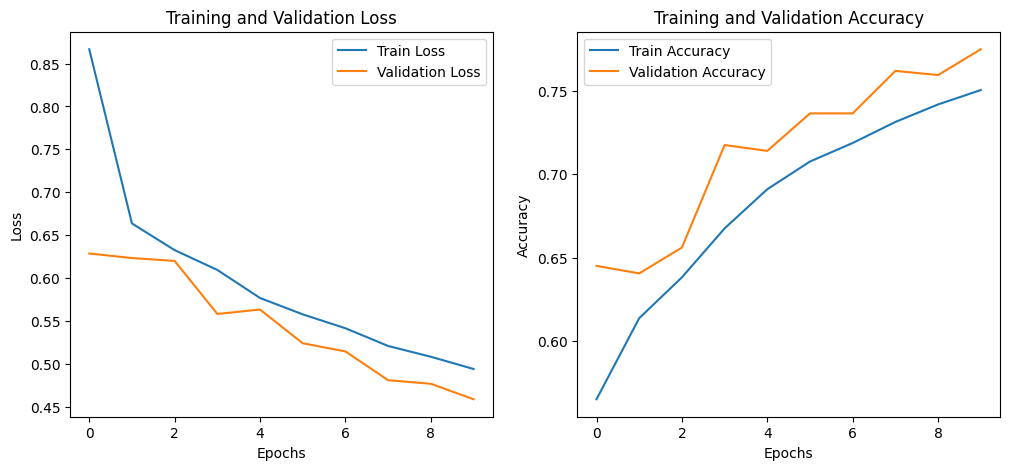

In [50]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [51]:
import itertools
from sklearn.metrics import accuracy_score

param_space = {
    'channels': [32, 64, 128],
    'filters': [32, 64, 128],
    'dropout_base': [0.1, 0.25, 0.5],
    'learning_rate': [0.01, 0.001, 0.0001],
    'weight_decay': [0.0001, 0.00001]
}

def train_evaluate_model(model, train_loader, val_loader, optimizer, criterion, epochs=1):
    best_val_acc = 0

    for epoch in range(epochs):

        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs, labels
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs, labels
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        if val_acc > best_val_acc:
            best_val_acc = val_acc

    return best_val_acc

In [52]:
#grid search
best_accuracy = 0
best_param = None

for params in itertools.product(*param_space.values()):
    current_param = dict(zip(param_space.keys(), params))
    print(f"\nparameters: {current_param}")

    model = CNNModel(
        channels=current_param['channels'],
        filters=current_param['filters'],
        dropout_base=current_param['dropout_base']
    )

    optimizer = optim.Adam(
        model.parameters(),
        lr=current_param['learning_rate'],
        weight_decay=current_param['weight_decay']
    )

    criterion = nn.CrossEntropyLoss()

    #train and evaluate
    val_accuracy = train_evaluate_model(
        model, train_loader, val_loader,
        optimizer, criterion
    )

    print(f"Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_param = current_param

print("\nGrid Search Complete!")
print("\nBest Parameters Found:")
for param, value in best_param.items():
    print(f"{param}: {value}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")


parameters: {'channels': 32, 'filters': 32, 'dropout_base': 0.1, 'learning_rate': 0.01, 'weight_decay': 0.0001}
Validation Accuracy: 0.6065

parameters: {'channels': 32, 'filters': 32, 'dropout_base': 0.1, 'learning_rate': 0.01, 'weight_decay': 1e-05}
Validation Accuracy: 0.5970

parameters: {'channels': 32, 'filters': 32, 'dropout_base': 0.1, 'learning_rate': 0.001, 'weight_decay': 0.0001}
Validation Accuracy: 0.6940

parameters: {'channels': 32, 'filters': 32, 'dropout_base': 0.1, 'learning_rate': 0.001, 'weight_decay': 1e-05}
Validation Accuracy: 0.6880

parameters: {'channels': 32, 'filters': 32, 'dropout_base': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.0001}
Validation Accuracy: 0.6300

parameters: {'channels': 32, 'filters': 32, 'dropout_base': 0.1, 'learning_rate': 0.0001, 'weight_decay': 1e-05}
Validation Accuracy: 0.6625

parameters: {'channels': 32, 'filters': 32, 'dropout_base': 0.25, 'learning_rate': 0.01, 'weight_decay': 0.0001}
Validation Accuracy: 0.5580

paramete

**FINAL MODEL**

In [53]:
#mine
final_model = CNNModel(channels=128, filters=64, dropout_base=0.1)
optimizer = optim.Adam(final_model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_acc, val_acc = [], []

print("Training final model...")
for epoch in range(5):
    final_model.train()
    total_train_loss = 0
    correct_train_preds = 0
    total_train_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs, labels
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train_samples += labels.size(0)
        correct_train_preds += predicted.eq(labels).sum().item()

    final_model.eval()
    total_val_loss = 0
    correct_val_preds = 0
    total_val_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs, labels
            outputs = final_model(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val_samples += labels.size(0)
            correct_val_preds += predicted.eq(labels).sum().item()

    train_losses.append(total_train_loss / len(train_loader))
    val_losses.append(total_val_loss / len(val_loader))
    train_acc.append(correct_train_preds / total_train_samples)
    val_acc.append(correct_val_preds / total_val_samples)

    print(f'Epoch [{epoch+1}/5]')
    print(f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}')
    print(f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}')

final_model.eval()
true_labels = []
pred_scores = []
class_correct = {0: 0, 1: 0}
class_total = {0: 0, 1: 0}

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs, labels
        outputs = final_model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        true_labels.extend(labels.numpy())
        pred_scores.extend(probabilities[:, 1].numpy())

        for label in range(2):
            mask = labels == label
            class_correct[label] += (predicted[mask] == labels[mask]).sum().item()
            class_total[label] += mask.sum().item()

overall_accuracy = sum(class_correct.values()) / sum(class_total.values())
cat_accuracy = class_correct[0] / class_total[0]
dog_accuracy = class_correct[1] / class_total[1]

fpr, tpr, _ = roc_curve(true_labels, pred_scores)
auroc_score = auc(fpr, tpr)


Training final model...
Epoch [1/5]
Train Loss: 0.7299, Train Acc: 0.5994
Val Loss: 0.6142, Val Acc: 0.6825
Epoch [2/5]
Train Loss: 0.6227, Train Acc: 0.6528
Val Loss: 0.5929, Val Acc: 0.6885
Epoch [3/5]
Train Loss: 0.5917, Train Acc: 0.6807
Val Loss: 0.5496, Val Acc: 0.7285
Epoch [4/5]
Train Loss: 0.5659, Train Acc: 0.7014
Val Loss: 0.5188, Val Acc: 0.7420
Epoch [5/5]
Train Loss: 0.5337, Train Acc: 0.7302
Val Loss: 0.5370, Val Acc: 0.7325


In [60]:
final_model = CNNModel(channels=128, filters=64, dropout_base=0.1)
optimizer = optim.Adam(final_model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_acc, val_acc = [], []
test_acc = []

print("Training final model...")
for epoch in range(10):
    final_model.train()
    total_train_loss = 0
    correct_train_preds = 0
    total_train_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs, labels
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train_samples += labels.size(0)
        correct_train_preds += predicted.eq(labels).sum().item()

    final_model.eval()
    total_val_loss = 0
    correct_val_preds = 0
    total_val_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs, labels
            outputs = final_model(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val_samples += labels.size(0)
            correct_val_preds += predicted.eq(labels).sum().item()

    train_losses.append(total_train_loss / len(train_loader))
    val_losses.append(total_val_loss / len(val_loader))
    train_acc.append(correct_train_preds / total_train_samples)
    val_acc.append(correct_val_preds / total_val_samples)

    # Displaying progress at the end of each epoch
    print(f'Epoch [{epoch+1}/10]')  # Changed epoch to 10
    print(f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}')
    print(f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}')

    final_model.eval()
    correct_test_preds = 0
    total_test_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs, labels
            outputs = final_model(inputs)
            _, predicted = outputs.max(1)
            total_test_samples += labels.size(0)
            correct_test_preds += predicted.eq(labels).sum().item()

    test_accuracy = correct_test_preds / total_test_samples
    test_acc.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.4f}')


final_model.eval()
y_true = []
y_scores = []
class_correct = {0: 0, 1: 0}
class_total = {0: 0, 1: 0}

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs, labels
        outputs = final_model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        y_true.extend(labels.numpy())  # For ROC curve
        y_scores.extend(probabilities[:, 1].numpy())

        for label in range(2):  # For per-class accuracy
            mask = labels == label
            class_correct[label] += (predicted[mask] == labels[mask]).sum().item()
            class_total[label] += mask.sum().item()

overall_accuracy = sum(class_correct.values()) / sum(class_total.values())
cat_accuracy = class_correct[0] / class_total[0]
dog_accuracy_accuracy = class_correct[1] / class_total[1]

fpr, tpr, _ = roc_curve(y_true, y_scores)
auroc_score = auc(fpr, tpr)

print(f'Overall Accuracy: {overall_accuracy:.4f}')
print(f'CAT Accuracy: {cat_accuracy:.4f}')
print(f'DOG Accuracy: {dog_accuracy:.4f}')
print(f'AUROC: {auroc_score:.4f}')


Training final model...
Epoch [1/10]
Train Loss: 0.7534, Train Acc: 0.5859
Val Loss: 0.6397, Val Acc: 0.6455
Test Accuracy: 0.6340
Epoch [2/10]
Train Loss: 0.6180, Train Acc: 0.6589
Val Loss: 0.5880, Val Acc: 0.6905
Test Accuracy: 0.6815
Epoch [3/10]
Train Loss: 0.5891, Train Acc: 0.6811
Val Loss: 0.5815, Val Acc: 0.7000
Test Accuracy: 0.6805
Epoch [4/10]
Train Loss: 0.5680, Train Acc: 0.7019
Val Loss: 0.5453, Val Acc: 0.7150
Test Accuracy: 0.7140
Epoch [5/10]
Train Loss: 0.5361, Train Acc: 0.7236
Val Loss: 0.5111, Val Acc: 0.7415
Test Accuracy: 0.7375
Epoch [6/10]
Train Loss: 0.5272, Train Acc: 0.7315
Val Loss: 0.5129, Val Acc: 0.7430
Test Accuracy: 0.7475
Epoch [7/10]
Train Loss: 0.5148, Train Acc: 0.7426
Val Loss: 0.4883, Val Acc: 0.7580
Test Accuracy: 0.7555
Epoch [8/10]
Train Loss: 0.4953, Train Acc: 0.7560
Val Loss: 0.4864, Val Acc: 0.7605
Test Accuracy: 0.7625
Epoch [9/10]
Train Loss: 0.4871, Train Acc: 0.7605
Val Loss: 0.4641, Val Acc: 0.7775
Test Accuracy: 0.7740
Epoch [10/10]

In [63]:
# prompt: fetch teh test /train accuarcy from above code

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f'Overall Accuracy: {overall_accuracy:.4f}')
print(f'CAT Accuracy: {cat_accuracy:.4f}')
print(f'DOG Accuracy: {dog_accuracy:.4f}')
print(f"Train Accuracy from last epoch: {train_acc[-1]:.4f}")
print(f"Validation Accuracy from last epoch: {val_acc[-1]:.4f}")

Test Accuracy: 0.7675
Overall Accuracy: 0.7675
CAT Accuracy: 0.8380
DOG Accuracy: 0.8600
Train Accuracy from last epoch: 0.7705
Validation Accuracy from last epoch: 0.7770



Final Results:
Overall Accuracy: 0.7675
AUROC Score: 0.8537
Cat Accuracy: 0.8380
Dog Accuracy: 0.8600


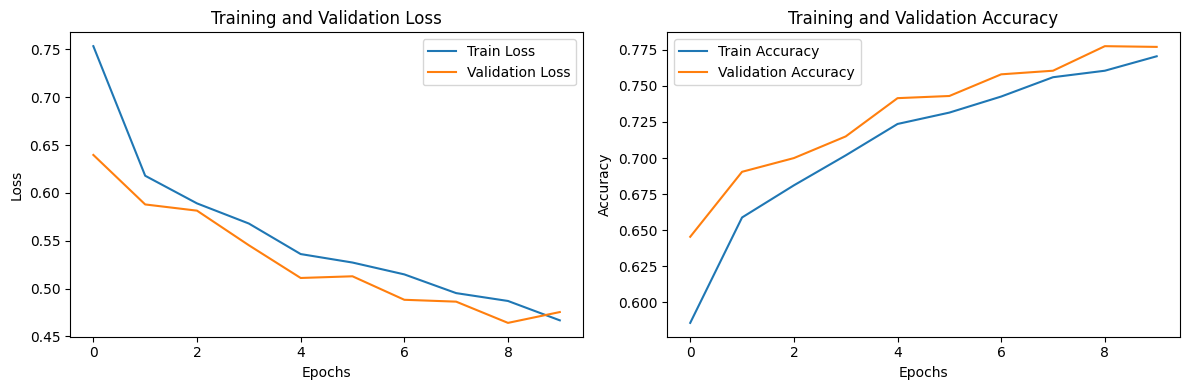

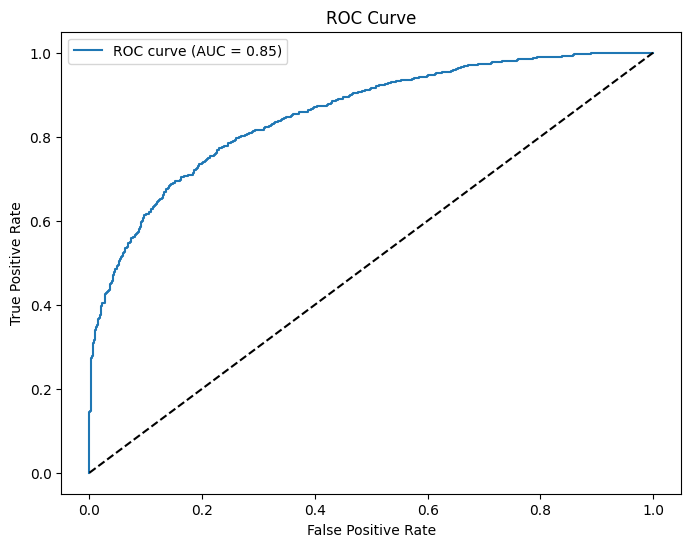

In [61]:
print("\nFinal Results:")
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"AUROC Score: {auroc_score:.4f}")
print(f"Cat Accuracy: {cat_accuracy:.4f}")
print(f"Dog Accuracy: {dog_accuracy:.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auroc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()